In [28]:
import os
import numpy as np
from PIL import Image

data_dir = "../data/training/1st_manual"
img_path = os.path.join(data_dir, "21_manual1.gif")
img = Image.open(img_path)
img = np.array(img) / 255


In [29]:
from skimage import morphology

skeleton = np.array(morphology.skeletonize(img), dtype=int)
binary = np.array(skeleton > 0, dtype=int)


In [ ]:
import enum

class Color(enum.Enum):
    RED = 1
    GREEN = 2
    BLUE = 3
    PURPLE=4

In [40]:
def to_image(x):
    x = x.astype(int)
    output = np.dstack([np.zeros_like(x)]*3)
    colors = {0: [0, 0, 0], 1: [255, 255, 255], 4: [
        255, 0, 0], 3: [0, 255, 0], 2: [0, 0, 255]}

    for k, v in colors.items():
        output[x == k] = np.array(v)
    return output


In [31]:
h, w = skeleton.shape
d = 1
conv = np.zeros_like(skeleton)
for i, j in zip(*np.where(skeleton > 0)):
    conv[i, j] = np.sum(skeleton[i-d:i+d+1, j-d:j+d+1])-1

ends = np.zeros_like(skeleton)
nodes = np.zeros_like(skeleton)
ends[conv == 1] = 1


In [32]:
branches = set(zip(*np.where(conv > 2)))


In [33]:
import itertools
offsets = list(
    filter(
        np.any, map(np.array, itertools.product([-1, 0, 1], repeat=2))
    )
)
indexs = branches.copy()
clusters = []
while indexs:
    start = indexs.pop()
    working = set([start])
    visited = set()

    while working:
        curr = working.pop()
        new = filter(
            lambda x: x not in visited and x in branches,
            map(lambda x: tuple(x + curr), offsets),
        )
        working.update(new)
        visited.add(curr)

    clusters.append(visited)
    indexs.difference_update(visited)


In [34]:
for cluster in clusters:
    if len(cluster) > 1:
        local = []
        for i, j in cluster:
            F = (
                binary[i - 1, j]
                + binary[i + 1, j]
                + binary[i, j - 1]
                + binary[i, j + 1]
            )
            E = (
                binary[i - 1, j - 1]
                + binary[i - 1, j + 1]
                + binary[i + 1, j - 1]
                + binary[i + 1, j + 1]
            )

            N = F + E
            W = 4 * N + 3 * F + 2 * E
            local.append((W, i, j))
        if local:
            local.sort(reverse=True)
            nodes[local[0][1:]] = 1


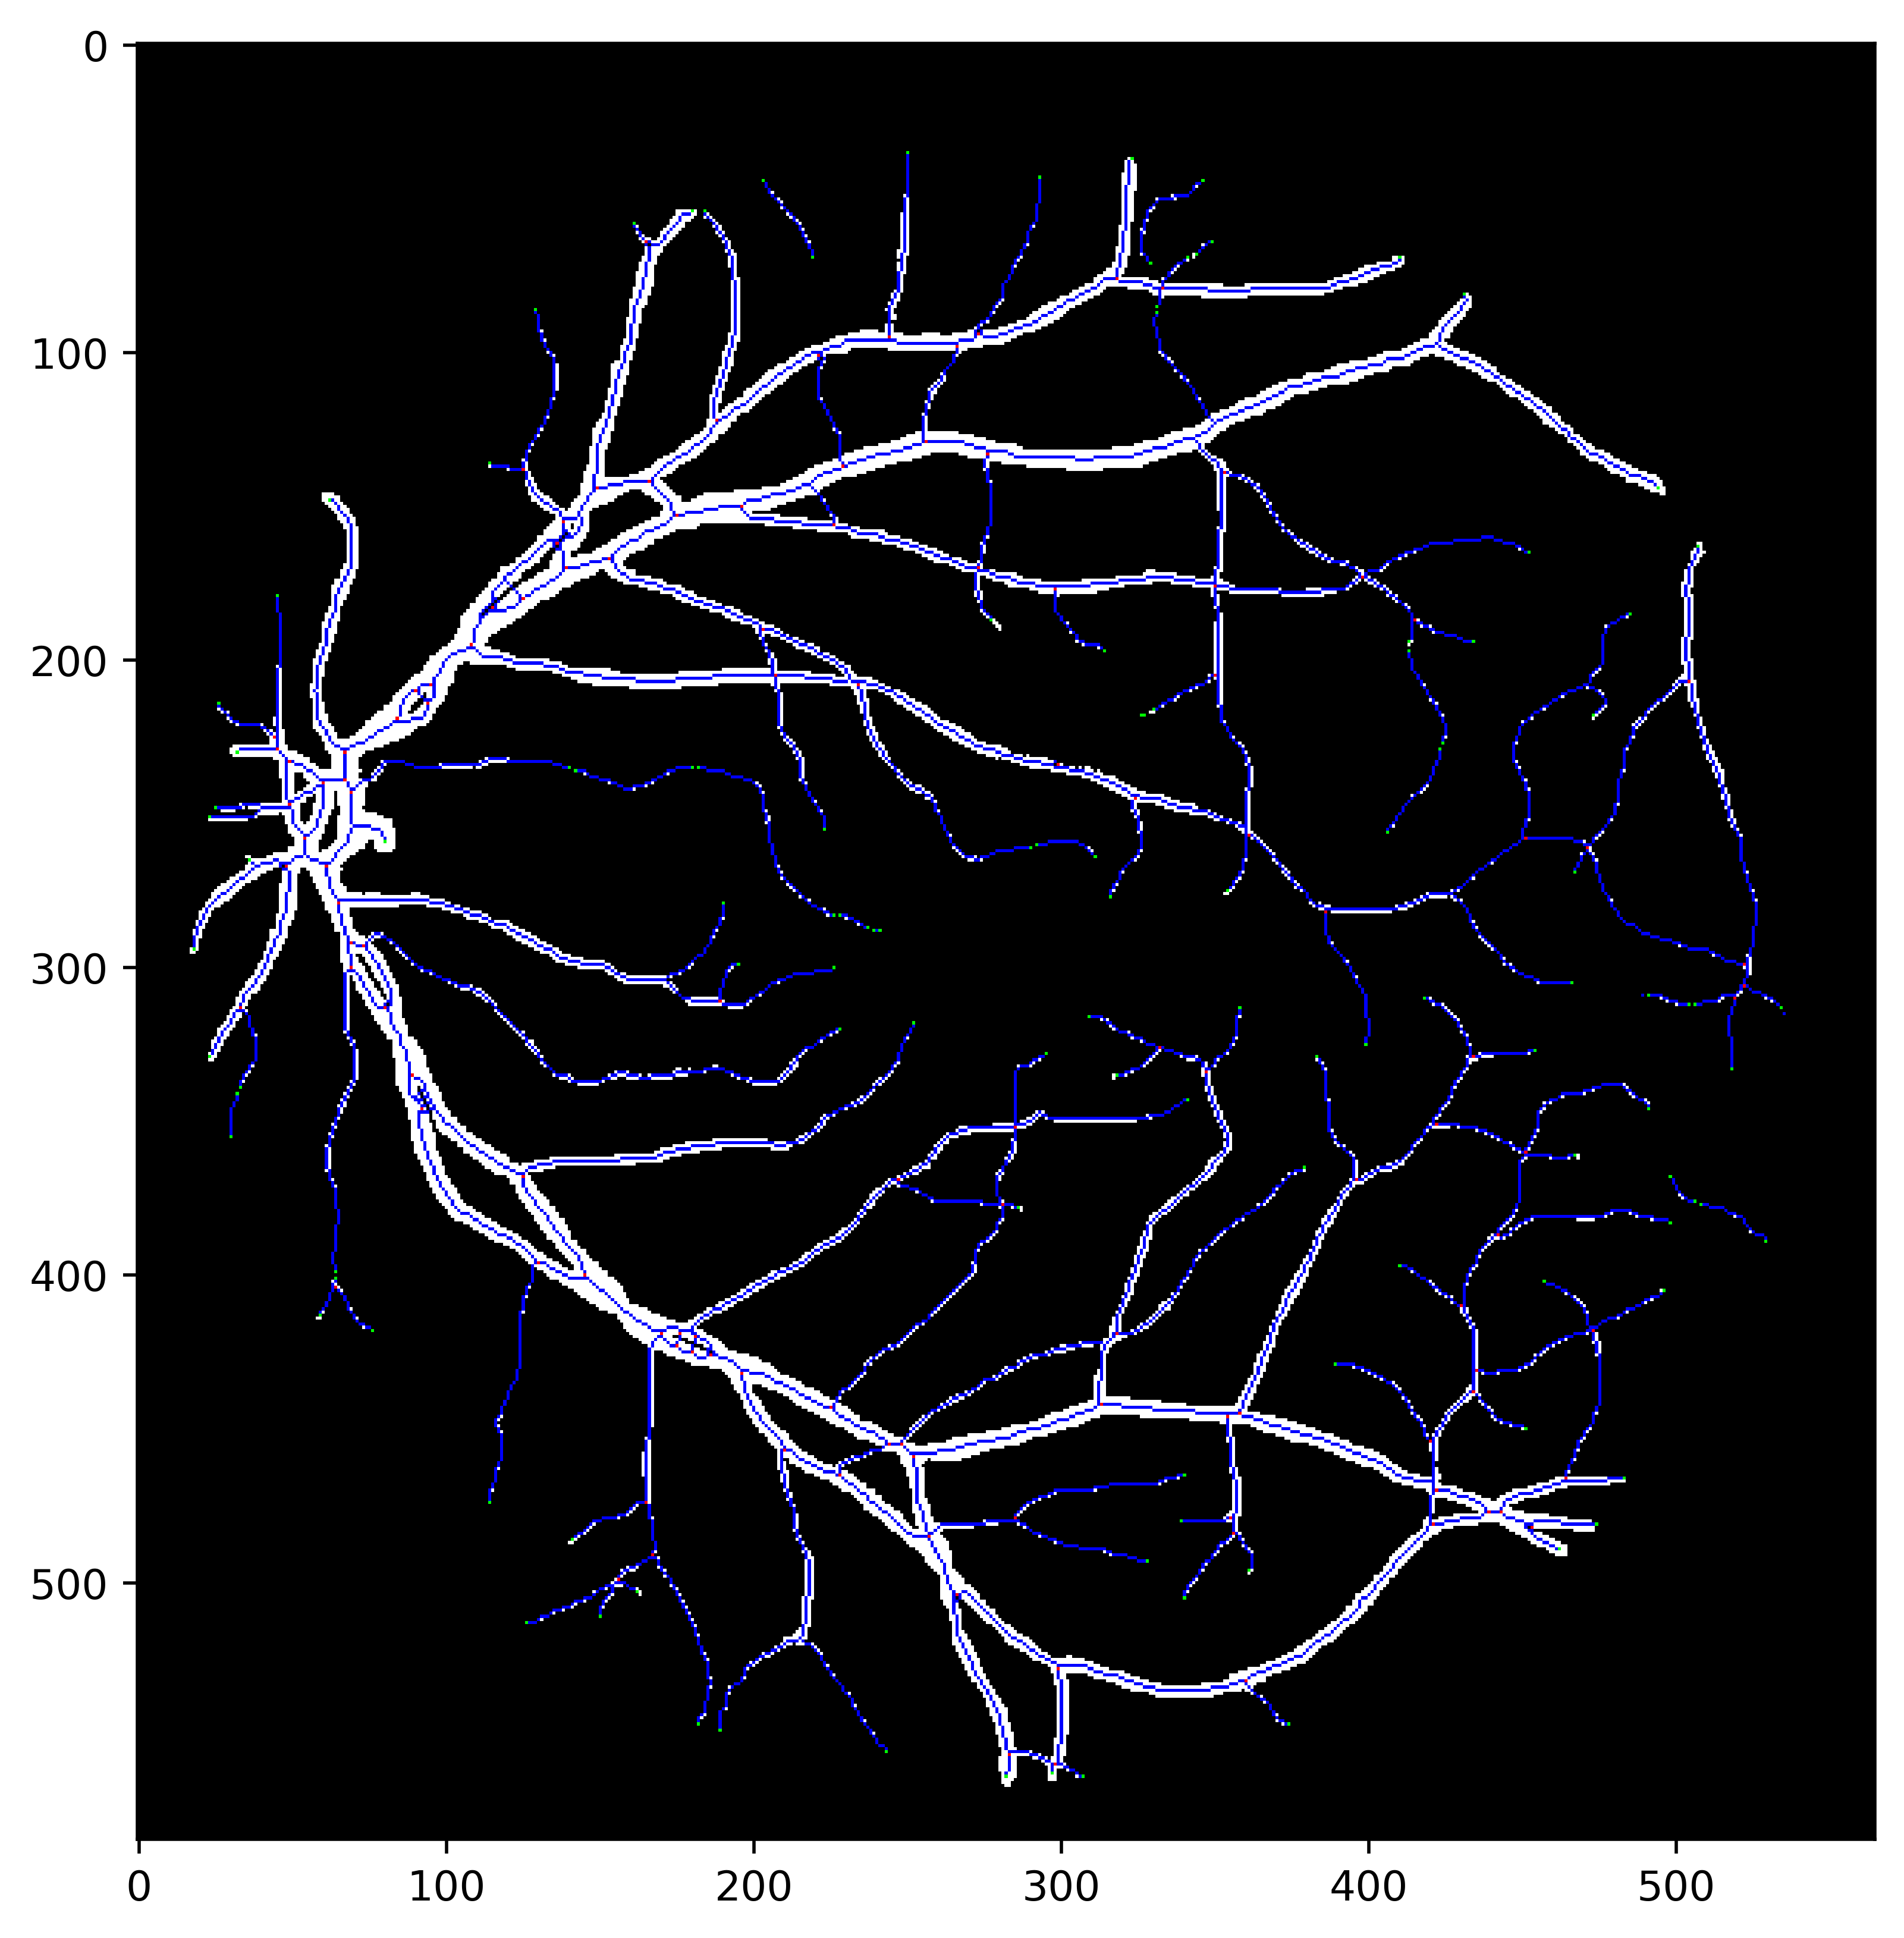

In [42]:
import matplotlib.pyplot as plt

l = [img, skeleton * 2, ends * 3, nodes * 4]
output = np.zeros_like(skeleton)
for i in l:
    output = np.maximum(output, i)


plt.figure(figsize=(8, 8), dpi=500)
plt.imshow(to_image(output))


In [9]:
np.where(conv > 1)[0].shape


(22891,)